Gradient descent did not work because the derivative doesn't really exist and there are tons of local maxima. In the notebook I will implement and test swarm optimization instead.

In [1]:
import random
import math
import duckdb
import importlib
import optimized_fractals as of
importlib.reload(of) # Reload modules actively being developed

<module 'optimized_fractals' from 'c:\\Users\\aiden\\Fractals\\optimized_fractals.py'>

In [2]:

class particle:

    def __init__(self, parameters, resolution):
        self.parameters = parameters
        self.best_parameters = parameters.copy()
        self.velocity = [0.0] * len(parameters)
        self.fitness = of.surface_area(resolution, resolution, 4.0 / resolution, 0.0, 0.0, parameters)
        self.best_fitness = self.fitness


    def step(self, resolution):

        for i in range(len(self.parameters)):
            self.parameters[i] += self.velocity[i]

        # Recalculate fitness and update best variables if necessary
        self.fitness = of.surface_area(resolution, resolution, 4.0 / resolution, 0.0, 0.0, self.parameters)
        if self.fitness > self.best_fitness:
            self.best_fitness = self.fitness
            self.best_parameters = self.parameters.copy()

    def update_velocity(self, w, c1, c2, best_parameters):

        for i in range(len(self.velocity)):
            r1 = random.uniform(0.0, 1.0)
            r2 = random.uniform(0.0, 1.0)
            self.velocity[i] = w * self.velocity[i] + r1*c1*(self.best_parameters[i] - self.parameters[i]) + r2*c2*(best_parameters[i] - self.parameters[i])


class swarm:

    def __init__(self, particles, w, c1, c2):

        self.particles = particles

        self.best_parameters = []
        self.best_fitness = 0

        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.update_best()

        # Initialize particle velocities
        for particle in self.particles:
            particle.velocity = [random.uniform(-0.01,0.01) for i in range(len(particle.velocity))]

    def update_best(self):
        # Find best parameters and position across all particles
        for particle in self.particles:
            if particle.best_fitness > self.best_fitness:
                self.best_fitness = particle.best_fitness
                self.best_parameters = particle.best_parameters.copy()


    def step(self, resolution):

        for particle in self.particles:

            particle.step(resolution)

            particle.update_velocity(self.w, self.c1, self.c2, self.best_parameters)

            # Check if updated particle has better fitness
            if particle.fitness > self.best_fitness:
                self.best_fitness = particle.fitness
                self.best_parameters = particle.best_parameters
    

In [305]:
def get_rand_starting_parameters(N):
    conn = duckdb.connect("FractalData.duckdb")
    rand_parameters = conn.execute("SELECT * EXCLUDE(surface_area, size) FROM StartingParameters WHERE surface_area > 100 USING SAMPLE " + str(N) + " ROWS").fetchall()
    conn.close()
    return rand_parameters


# Runs PSO on input parameters and returns list of best_fitness
def hyperparameter_test(parameters, w, c1, c2, iters):

    test_swarm = swarm([particle(list(parameter),1024) for parameter in parameters], w, c1, c2)

    for _ in range(iters):
        test_swarm.step(1024)

    return test_swarm.best_fitness




In [ ]:
# Basic gradient descent optimizer for POS with N=20 and resolution = 1024, trying to do hyperparameter optimization
def gradient_step(hyperparameters, step_size, sample_size):

    # Sum of each partial across 
    wPartialSum = 0
    c1PartialSum = 0
    c2PartialSum = 0

    for i in range(sample_size):

        # Find random set of starting parameters
        parameters = get_rand_starting_parameters(30)

        # Find partial in each direction
        wPartial = hyperparameter_test(parameters, hyperparameters[0]-step_size, hyperparameters[1], hyperparameters[2], 100) - hyperparameter_test(parameters, hyperparameters[0]-step_size, hyperparameters[1], hyperparameters[2], 100)
        c1Partial = hyperparameter_test(parameters, hyperparameters[0], hyperparameters[1]+step_size, hyperparameters[2], 100) - hyperparameter_test(parameters, hyperparameters[0], hyperparameters[1]-step_size, hyperparameters[2], 100)
        c2Partial = hyperparameter_test(parameters, hyperparameters[0], hyperparameters[1], hyperparameters[2]+step_size, 100) - hyperparameter_test(parameters, hyperparameters[0], hyperparameters[1], hyperparameters[2]+step_size, 100)

        partialMaginitude = math.sqrt(wPartial*wPartial+c1Partial*c1Partial+c2Partial*c2Partial)

        wPartialSum += wPartial / partialMaginitude
        c1PartialSum += c1Partial / partialMaginitude
        c2PartialSum += c2Partial / partialMaginitude

    totalMagnitude = math.sqrt(wPartialSum*wPartialSum+c1PartialSum*c1PartialSum+c2PartialSum*c2PartialSum)

    return (hyperparameters[0] + step_size*wPartialSum/totalMagnitude, hyperparameters[1] + step_size*c1PartialSum/totalMagnitude, hyperparameters[2] + step_size*c2PartialSum/totalMagnitude)



In [332]:
hyperparameters = (0.7, 1.0, 1.0)
hyperparameter_history = [tuple(hyperparameters)]
hyperparameters = (0.5899833895730908, 1.0504564460209258, 0.8407816201404149)
hyperparameter_history.append(tuple(hyperparameters))

step_size = 0.2

while True:

    print("New step_size: " + str(step_size))

    # Run the proper number of iterations
    for _ in range(2):
        hyperparameters = gradient_step(hyperparameters, step_size, 30)
        print(hyperparameters)
        hyperparameter_history.append(tuple(hyperparameters))

    # Decrease step_size
    step_size = step_size / 2


New step_size: 0.2
(0.6880633118491566, 1.2074242610336223, 0.91655387031461)
(0.6506604336788765, 1.3642082649937641, 1.034959110092271)
New step_size: 0.1


KeyboardInterrupt: 

In [356]:
parameters = get_rand_starting_parameters(100)
swarm1 =  swarm([particle(list(parameter),2048) for parameter in parameters], 0.8, 2.0, 0.8)

fitness_history = []
parameter_history = []

for i in range(100000):

    print(i)
    
    print(swarm1.best_fitness)

    fitness_history.append(swarm1.best_fitness)
    parameter_history.append(swarm1.best_parameters)

    for j in range(100):
        swarm1.step(2048)

    if (i%30 == 0):
        past_best = swarm1.best_parameters.copy()
        parameters = get_rand_starting_parameters(99)
        swarm1 =  swarm([particle(list(parameter),1024) for parameter in parameters] + [particle(list(past_best),2048)], 0.8, 2.3, 0.8)



0
4524
1
27422
2
28390
3
28390
4
28458
5
28458
6
33466
7
33466
8
33466
9
42156
10
47050
11
48974
12
48988
13
49072
14
49140
15
49140
16
49140
17
49140
18
49140
19
49140
20
49140
21
49140
22
49140
23
49140
24
49140
25
49140
26
49140
27
49140
28
49140
29
49140
30
49140
31
49140
32
50552
33
50552
34
50552
35
60188
36
62980
37
64660
38
65442
39
69922
40
70508
41
70606
42
70606
43
70606
44
70606
45
70606
46
70606
47
70606
48
70606
49
70606
50
70606
51
70606
52
70606
53
70606
54
70606
55
70606
56
70606
57
70606
58
70606
59
70606
60
70606
61
70606
62
72714
63
73060
64
73060
65
73096
66
73122
67
73122
68
73122
69
73122
70
73122
71
73122
72
73122
73
73122
74
74098
75
74664
76
74664
77
74664
78
75356
79
75356
80
75562
81
75788
82
75788
83
75788
84
75788
85
75788
86
75788
87
75788
88
75788
89
75788
90
75788
91
75788
92
77746
93
77758
94
77784
95
77784
96
77784
97
77902
98
77902
99
77902
100
77902
101
77902
102
77902
103
77902
104
77902
105
77902
106
77902
107
77902
108
77902
109
77902
110
77902
1

KeyboardInterrupt: 

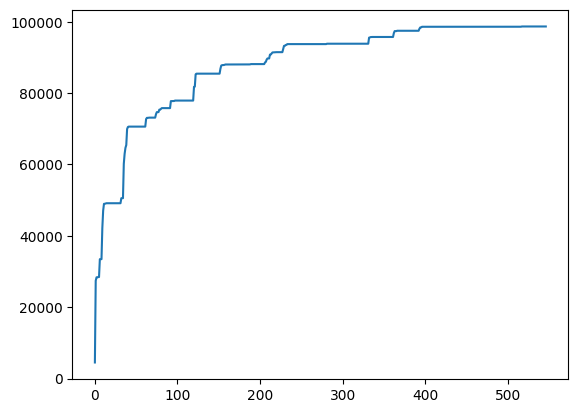

In [357]:
import matplotlib.pyplot as plt
plt.plot(fitness_history)

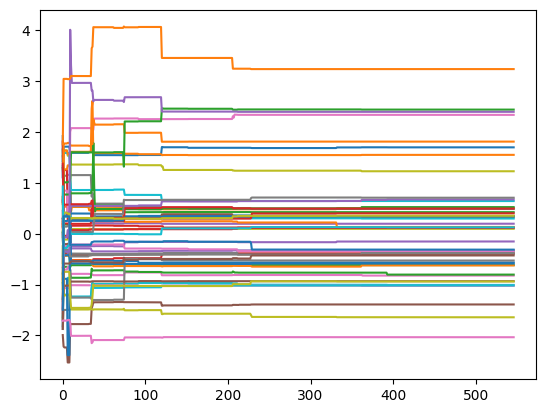

In [358]:
for i in range(52):

    plt.plot([p[i] for p in parameter_history])

In [2]:
decent_parameters2 = [0.6446593108468839,
 0.41065442910736094,
 0.5619150815024497,
 0.24057121937100556,
 -0.11451331980603159,
 -0.9234983847144425,
 1.1008914960474077,
 -1.3280727358658992,
 1.0522675119712526,
 0.5886927890431185,
 -0.6382405770493343,
 0.5241723145166398,
 -0.5385942850303663,
 -1.9447671065553298,
 0.34020189121414834,
 2.2057355752556713,
 0.5981402107056478,
 -0.6697270678655568,
 -1.5305238785378188,
 0.6185199349780557,
 0.07483030625108254,
 0.7728556205337962,
 0.38393757865327865,
 -0.029292942118757027,
 -1.8600804059758298,
 0.03888015629218457,
 0.16161662528466106,
 1.1789002590999553,
 0.2747390974373857,
 3.1148637802277426,
 -0.2324769448572339,
 0.7863131822417697,
 -0.5509884249404513,
 -0.22429046737629169,
 1.2377277332774714,
 -1.2656075072049082,
 -1.7898635457420509,
 0.3412040285566523,
 1.1652783041719075,
 -0.9477682330123701,
 -4.09119110809707,
 4.287319833620435,
 0.8279524683657288,
 0.4003167560586893,
 -1.2999635379595822,
 -10.157150130895266,
 -0.4735610276414879,
 0.38232954875778274,
 -2.5532656193510217,
 0.7650740258346344,
 0.7415694472207137,
 -1.9142382191412763]

In [4]:
resolution = 4096

of.generate_standard_fractal(resolution, resolution, 4.0/resolution, 0.0, 0.0, 400, [0]*12, decent_parameters2, "images/bestSoFar2.png")
of.generate_standard_fractal(resolution, resolution, 4.0/resolution, 0.0, 0.0, 400, [0]*12, decent_parameters3, "images/bestSoFar3.png")

In [3]:
decent_parameters3 = [0.3441029018048667,
 0.5002697426209395,
 -0.6169348665342972,
 -0.38634441780572915,
 0.19623588489052055,
 -0.3948061310753242,
 -0.8226843168101444,
 0.4850864986448001,
 1.2271035476790175,
 -1.0065254157231367,
 1.6968098078549803,
 -0.6228441973356696,
 -0.8037644632136335,
 0.12367766905236802,
 -0.32570966899324083,
 0.323743024706902,
 -1.0242932828391134,
 -0.338491723063957,
 0.0959961261525691,
 -1.0175237289041683,
 -0.566398014568082,
 0.1319600974673232,
 0.4233554757802259,
 0.11334218670054019,
 -0.15280685307817007,
 -1.3904444675453767,
 2.3348424598608593,
 -0.527371289942644,
 -1.6424938280080181,
 0.6416434566282085,
 -0.5841993584323882,
 1.5492050895279883,
 0.522511851273885,
 0.4935823419344953,
 0.6730481333423951,
 -0.9328314769046416,
 -0.3418523935389831,
 -0.3798784049149241,
 -0.9388508114484714,
 0.29815255491960396,
 0.3464026345517023,
 1.809701588226687,
 2.4384779199654885,
 0.4001465027157664,
 2.395034625695819,
 -0.42732938985404023,
 -2.034204623230245,
 0.706964330888674,
 0.35278871291493646,
 0.1252410731194393,
 -0.31320694657655596,
 3.234609985534318]

In [ ]:
of.surface_area(1024,1024,4.0/1024,0.0,0.0,decent_parameters3)

26914

In [ ]:
of.generate